# Reweighting

*Properties of the reweighting procedure for observable $\Sigma$*

## Function definitions

- load the necessary modules:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

- read complex eigenvalues of one configuration:

In [2]:
def readCEVs(eigFile):
# eigFile - name of .eig file with eigenvalues
    cevs = np.loadtxt(eigFile)
    return np.array([np.complex128(cev[0] + cev[1] * 1j) for cev in cevs])

- read complex eigenvalues of all configurations at once:

In [3]:
def readAllCEVs(eigFilesList):
# eigFilesList - list of .eig file names
    f = open(eigFilesList, "r")
    allCEVs = []
    for eigFileName in f:
        allCEVs.append(readCEVs(eigFileName.strip()))
    f.close()
    return allCEVs

- absolute value of topological charge is equal to the number of zero modes:

In [4]:
def countZeros(cevs):
# cevs - complex eigenvalues of one configuration
    return len([cev for cev in cevs if abs(cev) < 1e-12])

- computes determinant of a massive overlap operator using eigenvalues:

In [5]:
def detM(cevs, qm, nmz, out):
# cevs - complex eigenvalues
# qm - quark mass
# nmz - numerical normalization (about 0.63 is optimal)
# out - print complex p if True
    f = 1.0 - qm / 2.0
    p = np.complex128(1 + 0j)
    for i in range(len(cevs)):
        p *= (f * cevs[i] + qm) * nmz
    if out: print(p)
    return p.real

- computes normalized determinants (max = 1) of an ensemble:

In [6]:
def detEnMax1(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
    dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]
    dmax = max(dets)
    return [d / dmax for d in dets]

- sort determinants according to absolute topological charge:

In [7]:
def QdetEnMax1(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass

    # compute determinants for all configuration
    dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]

    # normalize determinants to max is equal to one
    dmax = max(dets)
    dets = [d / dmax for d in dets]

    # compute absolute topological charge
    Qs = [countZeros(cevs) for cevs in allCEVs]

    # find maximal topological charge
    Qmax = int(max(Qs))
    print("Qmax =", Qmax)

    # create Qmax + 1 empty lists
    Qdet = []
    for i in range(Qmax + 1): Qdet.append([])

    # add determinants according to topological charge
    for i in range(len(dets)):
        Qdet[Qs[i]].append(dets[i])
        
    # how many entries are in each topological sector
    print([len(Qdet[i]) for i in range(Qmax + 1)])
    print()
    
    return Qdet

- compute $\Sigma$ from complex eigenvalues for a given quark mass `qm`:

In [8]:
def sigma(cevs, qm, out):
# cevs - list of complex eigenvalues
# qm - quark mass
# out - if True sigma is printed
    f = 1.0 - qm / 2.0
    s = np.complex128(0.0 + 0.0j) # sum
    for i in range(len(cevs)):
        s += (1.0 - 0.5 * cevs[i]) / (f * cevs[i] + qm)
    # len(cevs) is 2 * L^2 because of 2 spinor components
    sig = s / (len(cevs) * 0.5) # division by L^2
    if out: print(sig) # imaginary part should be near zero 
    return sig.real

- compute $\Sigma$ for a given quark mass `qm` for all configurations:

In [9]:
def sigmaEn(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
    sigmas = [sigma(cevs, qm, False) for cevs in allCEVs]
    return sigmas

## Examples

- read complex eigenvalues of one configuration:

In [10]:
cevs = readCEVs("/mnt/e/Jaime/b5_24x24Ov/L024x024_b05000i00001-HO.eig")
cevs[0]

(2.61181149955481e-16-4.57389018940462e-16j)

- compute determinant for quark mass 0.05:

In [11]:
detM(cevs, 0.05, 0.63, True)

(61.94225469173407-4.331646152877511e-12j)


61.94225469173407

- compute absolute value of topological charge:

In [12]:
countZeros(cevs)

1

In [13]:
sigma(cevs, 0.05, True)

(0.1079138023563277+9.574709852127543e-17j)


0.1079138023563277

## Results

- read complex eigenvalues of all configurations from an ensemble:

In [14]:
%%time
# set appropriate beta!
beta = 5.0
allCEVs = readAllCEVs("/mnt/e/Jaime/b5_24x24Ov.eigFilesList")

CPU times: user 3min 23s, sys: 5.14 s, total: 3min 28s
Wall time: 9min 6s


### Check $\Sigma$ reweighting

In [15]:
def sigVqm(allCEVs, maxNf, qmMin, qmMax, qmStep):
    qms = np.arange(qmMin, qmMax, qmStep)
    sigqm = [[qms, []] for i in range(maxNf + 1)]
    for qm in qms:
        dets = detEnMax1(allCEVs, qm)
        sigmas = sigmaEn(allCEVs, qm)
        for Nf in range(maxNf + 1):
            detNf = [d**Nf for d in dets]
            sumdetNf = sum(detNf)
            sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
            sigqm[Nf][1].append(sum(sigdetNf))
    return sigqm

In [16]:
%%time
sigqm = sigVqm(allCEVs, 2, 0.005, 0.151, 0.005)

CPU times: user 56min 48s, sys: 88.8 ms, total: 56min 48s
Wall time: 56min 48s


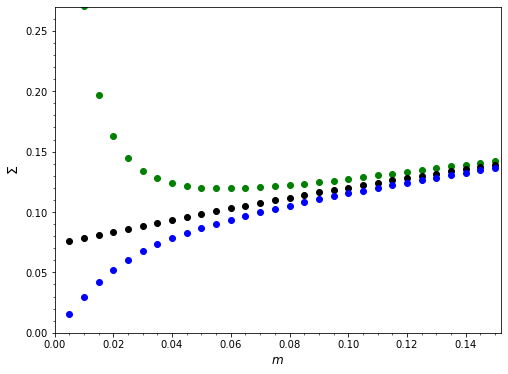

In [17]:
fig, p = plt.subplots(figsize = (8, 6))
p.set_xlabel("$m$", fontsize = 12)
p.set_ylabel(r"$\Sigma$", fontsize = 14)
p.set_xlim(0.0, 0.152)
p.set_ylim(0.0, 0.27)
p.set_xticks(np.arange(0, 0.152, 0.005), minor = True)
p.set_yticks(np.arange(0, 0.27, 0.01), minor = True)

p.scatter(sigqm[0][0], sigqm[0][1], color = "green")
p.scatter(sigqm[1][0], sigqm[1][1], color = "black")
p.scatter(sigqm[2][0], sigqm[2][1], color = "blue");

- correction for $\beta$, i.e. $g = 1/\sqrt{\beta}$:

In [18]:
%%time
# beta should have been set when reading CEVS
g = 1.0 / np.sqrt(beta)
gsigqm = [[[sigqm[j][k][i] / g for i in range(len(sigqm[j][k]))] for k in range(len(sigqm[j]))] for j in range(len(sigqm))]

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 46.3 µs


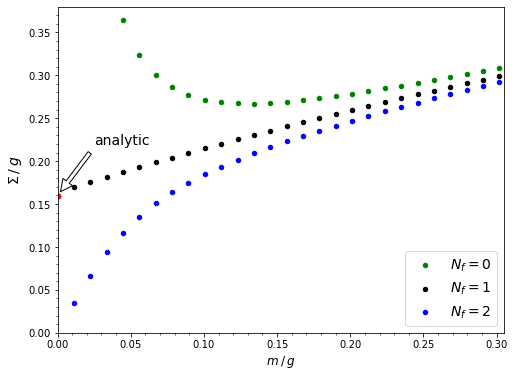

In [19]:
fig, p = plt.subplots(figsize = (8, 6))
p.set_xlabel("$m\:/\:g$", fontsize = 12)
p.set_ylabel(r"$\Sigma\:/\:g$", fontsize = 14)
p.set_xlim(0.0, 0.305)
p.set_ylim(0.0, 0.38)
p.set_xticks(np.arange(0, 0.305, 0.01), minor = True)
p.set_yticks(np.arange(0, 0.38, 0.01), minor = True)

p.scatter(gsigqm[0][0], gsigqm[0][1], s = 20, c = "green", label = "$N_f = 0$")
p.scatter(gsigqm[1][0], gsigqm[1][1], s = 20, c = "black", label = "$N_f = 1$")
p.scatter(gsigqm[2][0], gsigqm[2][1], s = 20, c = "blue", label = "$N_f = 2$")
p.plot(0.0, 0.1599, marker = "o", color = "red", markersize = 5)

p.annotate("analytic", xy = (0, 0.1599), xytext=(0.025, 0.22), fontsize = 14,
    arrowprops=dict(facecolor = "white", edgecolor = "black", shrink = 0.08))
p.legend(loc = "lower right", fontsize = 14);

- plot above can be directly compared to Fig. 1 in Duerr/Hoelbling Phys. Rev. D 69 (2004) 034503
- analytic result for $\Sigma/g$ for one flavor is 0.1599

### $\Sigma$ distributions

#### $\Sigma$ distribution (quenched) / m = 0.05

In [20]:
%%time
sigmas = sigmaEn(allCEVs, 0.05)

CPU times: user 20.3 s, sys: 0 ns, total: 20.3 s
Wall time: 20.3 s


In [21]:
sum(sigmas) / len(sigmas) # average sigma (quenched)

0.12010020024213586

In [22]:
(min(sigmas), max(sigmas))

(0.05617696253891176, 0.30895322962655547)

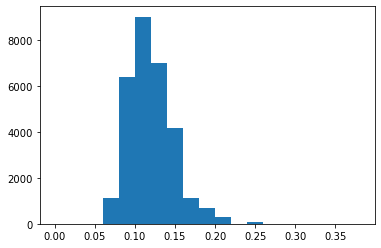

In [23]:
plt.hist(sigmas, bins = [r for r in np.arange(0.0, 0.4, 0.02)]);

#### $\Sigma$ times determinant (1 flavor) per configuration distribution / m = 0.05

In [24]:
%%time
dets = detEnMax1(allCEVs, 0.05)
sumdet1 = sum(dets)

CPU times: user 14.1 s, sys: 0 ns, total: 14.1 s
Wall time: 14.1 s


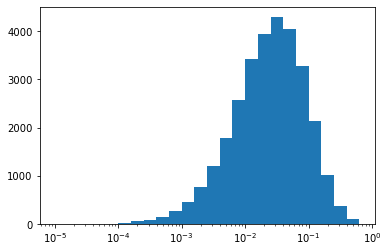

In [25]:
plt.xscale('log')
plt.hist(dets, bins = [10.0**r for r in np.arange(-5.0, 0, 0.2)]);

In [26]:
%%time
sigdet1 = [sigmas[i] * dets[i] / sumdet1 for i in range(len(sigmas))]
print("sigma = ", sum(sigdet1))
print()

sigma =  0.09845967884548093

CPU times: user 5.1 ms, sys: 0 ns, total: 5.1 ms
Wall time: 5.09 ms


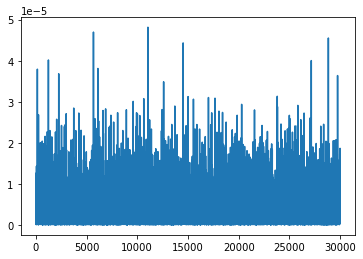

In [27]:
plt.plot(range(1, len(sigdet1) + 1), sigdet1);

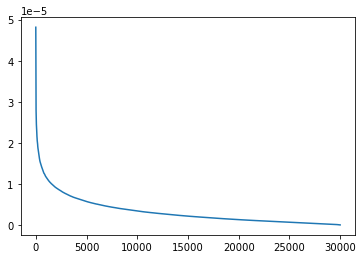

In [28]:
sigdet1.sort(reverse = True)
plt.plot(range(1, len(sigdet1) + 1), sigdet1);

In [29]:
(min(sigdet1), max(sigdet1))

(1.9962018364120877e-09, 4.815062170536316e-05)

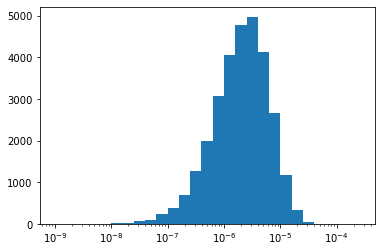

In [30]:
plt.xscale('log')
plt.hist(sigdet1, bins = [10.0**r for r in np.arange(-9.0, -3.5, 0.2)]);

#### $\Sigma$ times squared determinant (2 flavors) per configuration distribution / m = 0.05

In [31]:
%%time
dets = detEnMax1(allCEVs, 0.05)
det2 = [d**2 for d in dets]
sumdet2 = sum(det2)

CPU times: user 14.2 s, sys: 10 ms, total: 14.2 s
Wall time: 14.2 s


In [32]:
%%time
sigmas = sigmaEn(allCEVs, 0.05)
sigdet2 = [sigmas[i] * det2[i] / sumdet2 for i in range(len(sigmas))]
print("sigma = ", sum(sigdet2))
print()

sigma =  0.08656744246838888

CPU times: user 19.7 s, sys: 9.99 ms, total: 19.7 s
Wall time: 19.7 s


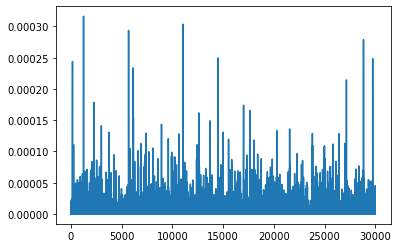

In [33]:
plt.plot(range(1, len(sigdet2) + 1), sigdet2);

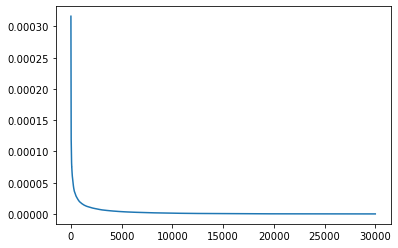

In [34]:
sigdet2.sort(reverse = True)
plt.plot(range(1, len(sigdet2) + 1), sigdet2);

In [35]:
(min(sigdet2), max(sigdet2))

(1.8259259638623377e-13, 0.0003163924280529878)

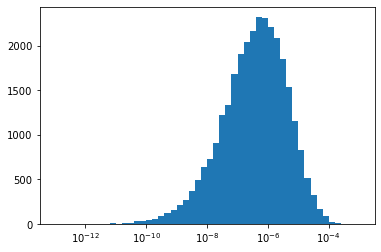

In [36]:
plt.xscale('log')
plt.hist(sigdet2, bins = [10.0**r for r in np.arange(-13.0, -2.8, 0.2)]);

### Cumulative plots

In [37]:
def cumSigmaNf(sigmas, dets, Nf):
    detNf = [d**Nf for d in dets]
    sumdetNf = sum(detNf)
    sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
    sigmaNf = sum(sigdetNf)
    sigdetNf.sort(reverse = True)
    csigdetNf = [sum(sigdetNf[:i]) / sigmaNf for i in range(1, len(sigdetNf) + 1)]
    return sigmaNf, csigdetNf 

In [38]:
def cumSigma(allCEVs, qm, flavors):
    fig, p = plt.subplots(figsize = (8, 5))  
    print("Nf    sigma     50%   90%   99%")
    print("===============================")
    dets = detEnMax1(allCEVs, qm)
    sigmas = sigmaEn(allCEVs, qm)
    for flavor in flavors:
        Nf, NfColor, NfLabel = flavor
        sigmaNf, csNf = cumSigmaNf(sigmas, dets, Nf)
        s50 = len([cs for cs in csNf if cs <= 0.50])
        s90 = len([cs for cs in csNf if cs <= 0.90])
        s99 = len([cs for cs in csNf if cs <= 0.99])
        print("%2d  %9.7f %5d %5d %5d " % (Nf, sigmaNf, s50, s90, s99))
        p.plot(range(1, len(csNf) + 1), csNf, color = NfColor, label = NfLabel)
    p.legend(loc = "lower right", fontsize = 14)

In [39]:
flavors = [[1, "black", "$N_f = 1$"], [2, "blue", "$N_f = 2$"],
    [4, "green", "$N_f = 4$"], [6, "violet", "$N_f = 6$"]]

#### m = 0.2

Nf    sigma     50%   90%   99%
 1  0.1551150  9375 23256 28836 
 2  0.1535875  5198 18139 26833 
 4  0.1512156  1288  8534 19262 
 6  0.1493832   234  3090 10626 


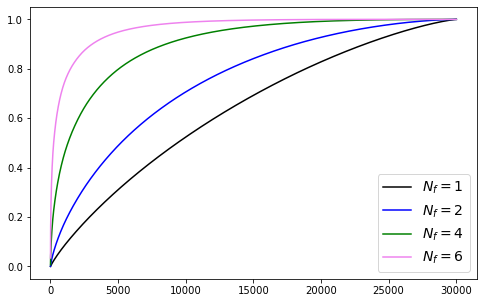

In [40]:
cumSigma(allCEVs, 0.2, flavors)

#### m = 0.1

Nf    sigma     50%   90%   99%
 1  0.1202486  7006 20564 27861 
 2  0.1153858  2569 12419 22898 
 4  0.1091456   238  2885  9958 
 6  0.1058304    20   454  2818 


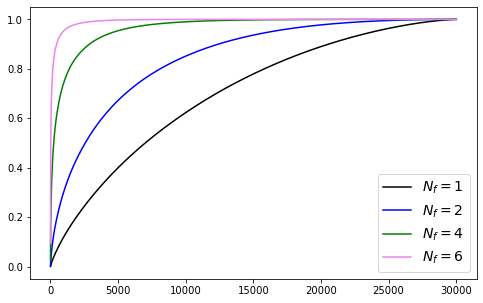

In [41]:
cumSigma(allCEVs, 0.1, flavors)

#### m = 0.05

Nf    sigma     50%   90%   99%
 1  0.0984597  5257 17779 26418 
 2  0.0865674  1241  7900 17880 
 4  0.0744143    66   920  4371 
 6  0.0690184     6   125   780 


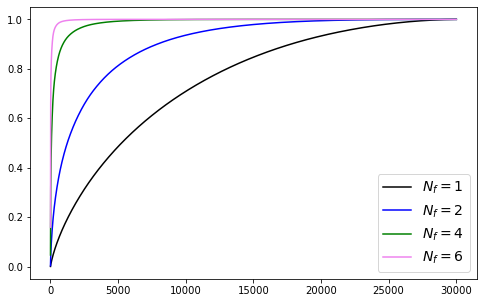

In [42]:
cumSigma(allCEVs, 0.05, flavors)

#### m = 0.01

Nf    sigma     50%   90%   99%
 1  0.0785254  3126 13041 22383 
 2  0.0295785   564  4024 10600 
 4  0.0147634    13   207  1116 
 6  0.0130972     1    28   160 


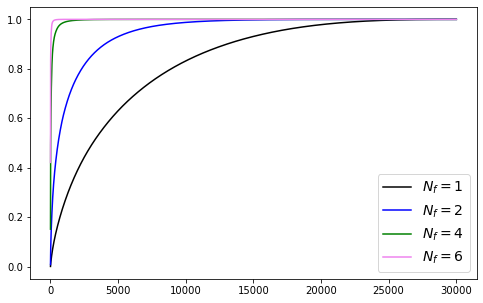

In [43]:
cumSigma(allCEVs, 0.01, flavors)

#### m = 0.001

Nf    sigma     50%   90%   99%
 1  0.0737777  1747  6973 16207 
 2  0.0031155   531  3743  9131 
 4  0.0014397    12   164   715 
 6  0.0013106     1    25   145 


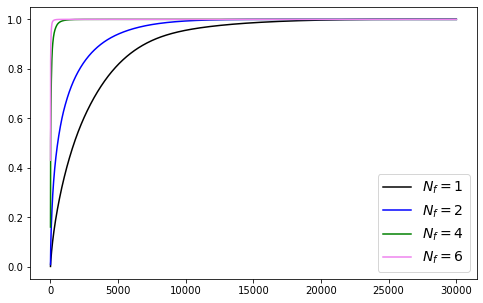

In [44]:
cumSigma(allCEVs, 0.001, flavors)

In [45]:
def cumSigmaVqm(allCEVs, qmMin, qmMax, qmStep, flavors, perc):
    maxNf = max([flavor[0] for flavor in flavors])
    sperc = [[] for i in range(maxNf + 1)]
    qms = np.arange(qmMin, qmMax, qmStep)
    for qm in qms:
        dets = detEnMax1(allCEVs, qm)
        sigmas = sigmaEn(allCEVs, qm)
        for flavor in flavors:
            Nf = flavor[0]
            sigmaNf, csNf = cumSigmaNf(sigmas, dets, Nf)
            sperc[Nf].append(len([cs for cs in csNf if cs <= perc]))
            print("%4.2f  %2d  %9.7f  %5d" % (qm, Nf, sigmaNf, sperc[Nf][-1]))
        print()
    fig, p = plt.subplots(figsize = (8, 5))
    for flavor in flavors:
        Nf, NfColor, NfLabel = flavor
        p.plot(qms, sperc[Nf], color = NfColor, label = NfLabel)
    p.set_xlim(0, None)
    p.set_ylim(0, None)
    p.legend(loc = "lower right", fontsize = 14)

0.02   1  0.0837081  24164
0.02   2  0.0521237  12711
0.02   4  0.0311114   1764
0.02   6  0.0264049    226

0.04   1  0.0936846  25890
0.04   2  0.0782169  16383
0.04   4  0.0628671   3387
0.04   6  0.0556825    556

0.06   1  0.1030911  26832
0.06   2  0.0935602  19187
0.06   4  0.0834504   5420
0.06   6  0.0793630   1055

0.08   1  0.1119348  27440
0.08   2  0.1053270  21305
0.08   4  0.0975673   7641
0.08   6  0.0941571   1800

0.10   1  0.1202486  27861
0.10   2  0.1153858  22898
0.10   4  0.1091456   9958
0.10   6  0.1058304   2818

0.12   1  0.1280702  28167
0.12   2  0.1243618  24120
0.12   4  0.1192894  12167
0.12   6  0.1161787   4090

0.14   1  0.1354360  28399
0.14   2  0.1325376  25061
0.14   4  0.1283890  14253
0.14   6  0.1255856   5567

0.16   1  0.1423791  28578
0.16   2  0.1400711  25797
0.16   4  0.1366549  16135
0.16   6  0.1341933   7215

0.18   1  0.1489297  28720
0.18   2  0.1470639  26374
0.18   4  0.1442288  17795
0.18   6  0.1420984   8917

0.20   1  0.1551150

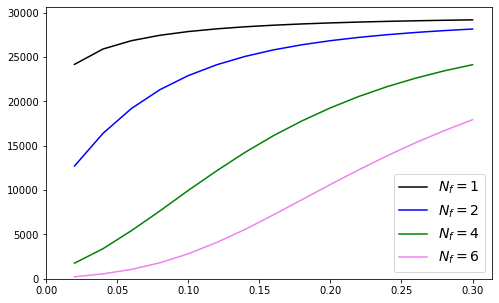

In [46]:
%%time
cumSigmaVqm(allCEVs, 0.02, 0.301, 0.02, flavors, 0.99)

0.00   1  0.0737777  16207
0.00   2  0.0031155   9131
0.00   4  0.0014397    715
0.00   6  0.0013106    145

0.01   1  0.0764231  21028
0.01   2  0.0183396   9730
0.01   4  0.0087197    900
0.01   6  0.0078600    149

0.01   1  0.0790486  22636
0.01   2  0.0322047  10821
0.01   4  0.0163175   1175
0.01   6  0.0144085    164

0.02   1  0.0816489  23603
0.02   2  0.0440953  11894
0.02   4  0.0243726   1493
0.02   6  0.0210106    191

0.02   1  0.0842199  24287
0.02   2  0.0539385  12913
0.02   4  0.0328222   1833
0.02   6  0.0277779    238

0.03   1  0.0867589  24824
0.03   2  0.0620015  13901
0.03   4  0.0413889   2197
0.03   6  0.0348296    305

0.03   1  0.0892641  25267
0.03   2  0.0686645  14841
0.03   4  0.0496767   2590
0.03   6  0.0421975    381

0.04   1  0.0917342  25635
0.04   2  0.0742828  15722
0.04   4  0.0573324   3023
0.04   6  0.0497369    475

0.04   1  0.0941686  25950
0.04   2  0.0791376  16541
0.04   4  0.0641649   3482
0.04   6  0.0571320    577

0.05   1  0.0965670

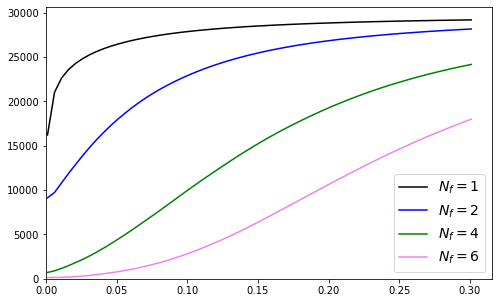

In [47]:
%%time
cumSigmaVqm(allCEVs, 0.001, 0.302, 0.005, flavors, 0.99)

0.00   1  0.0737777  16207
0.00   2  0.0031155   9131
0.00   4  0.0014397    715
0.00   6  0.0013106    145

0.00   1  0.0743080  18296
0.00   2  0.0062206   9182
0.00   4  0.0028819    736
0.00   6  0.0026211    146

0.00   1  0.0748378  19337
0.00   2  0.0093050   9267
0.00   4  0.0043287    767
0.00   6  0.0039314    146

0.00   1  0.0753670  20033
0.00   2  0.0123591   9388
0.00   4  0.0057825    807
0.00   6  0.0052413    147

0.01   1  0.0758954  20573
0.01   2  0.0153735   9544
0.01   4  0.0072455    853
0.01   6  0.0065508    147

0.01   1  0.0764231  21028
0.01   2  0.0183396   9730
0.01   4  0.0087197    900
0.01   6  0.0078600    149

0.01   1  0.0769500  21427
0.01   2  0.0212495   9935
0.01   4  0.0102070    949
0.01   6  0.0091689    151

0.01   1  0.0774761  21782
0.01   2  0.0240965  10153
0.01   4  0.0117092   1004
0.01   6  0.0104779    154

0.01   1  0.0780012  22100
0.01   2  0.0268744  10376
0.01   4  0.0132275   1060
0.01   6  0.0117872    157

0.01   1  0.0785254

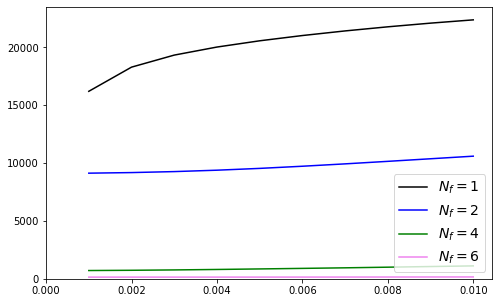

In [48]:
%%time
cumSigmaVqm(allCEVs, 0.001, 0.011, 0.001, flavors, 0.99)

## Topology

- topological charge of the first $n$ configurations which contribute most to the final value of $\Sigma$:

In [49]:
# key function for sorting: uses value of element[3]
def element3(element):
    return element[3]

def Q_first_n(allCEVs, qm, Nf, first_n):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
# Nf - number of flavors
# first_n - first n configurations of the sorted list

    # compute Qs, dets and sigmas for all configurations
    sdNf = [[countZeros(cevs),  detM(cevs, qm, 0.63, False),
            sigma(cevs, qm, False), 0.0] for cevs in allCEVs]
    
    # apply appropriate reweighting
    for i in range(len(sdNf)):
        sdNf[i][3] = sdNf[i][1]**Nf * sdNf[i][2]
    
    # sort according to the reweighted contributions
    sdNf.sort(key = element3, reverse = True)
    
    # take Q of the first n elements
    Qn = [sdNf[i][0] for i in range(first_n)]
    
    # how many entries are in each topological sector
    Qmax = int(max(Qn))
    Qc = [0 for i in range(Qmax + 1)]    
    for Q in Qn: Qc[Q] += 1
    print(Qc)
    print()
    
    return sdNf

- consistency check - distribution of all configurations:

In [50]:
%%time
sdNf = Q_first_n(allCEVs, 0.05, 6, 10000)

[3386, 4940, 1587, 87]

CPU times: user 36.4 s, sys: 0 ns, total: 36.4 s
Wall time: 36.4 s


- 203 configurations which contribute 99% for 6 flavors at $m = 0.05$:

In [51]:
%%time
sdNf = Q_first_n(allCEVs, 0.05, 6, 203)

[126, 77]

CPU times: user 36.4 s, sys: 0 ns, total: 36.4 s
Wall time: 36.4 s


In [52]:
sdNf[:30]

[[0, 1693.9687267271795, 0.05617696253891176, 1.3273656766250445e+18],
 [0, 1469.3816209543984, 0.05864305886312658, 5.902340170055158e+17],
 [1, 1356.838357857296, 0.08405511396983326, 5.244846918714118e+17],
 [1, 1344.295079220294, 0.082753325748726, 4.8837464659017754e+17],
 [0, 1382.8647408279712, 0.06497351078907741, 4.5437513264815405e+17],
 [1, 1317.9221913500892, 0.0818177530612245, 4.2873226955116346e+17],
 [0, 1319.030615114233, 0.06842669279480514, 3.603751239657502e+17],
 [1, 1211.591566186346, 0.08666018553308208, 2.7413031425138835e+17],
 [1, 1152.1981879717766, 0.08229137887510017, 1.9253844799869626e+17],
 [0, 1206.408509301415, 0.06091996576458569, 1.8781315201104406e+17],
 [0, 1153.605041337916, 0.06338283455415113, 1.4938759277248416e+17],
 [0, 1106.9386395648644, 0.061953222084143195, 1.1397384064350766e+17],
 [0, 1119.1944444123587, 0.05734773265681854, 1.1270664604146472e+17],
 [1, 1044.378524461673, 0.08349326344073688, 1.0834254509258534e+17],
 [0, 1100.23137247

- 58 configurations which contribute 99% for 6 flavors at $m = 0.01$:

In [53]:
%%time
sdNf = Q_first_n(allCEVs, 0.01, 6, 58)

[58]

CPU times: user 36.9 s, sys: 9.99 ms, total: 36.9 s
Wall time: 36.9 s


### Relative contributions to $\Sigma$

- relative contributions to $\Sigma$ from different topological sectors as a function of fermion mass 

In [54]:
def QrsigmaVqm(allCEVs, qmMin, qmMax, qmStep, Nf):
# allCEVs - eigenvalues for all configurations
# qmMin, qmMax, qmStep - range of quark masses
# Nf - number of flavors

    # compute absolute topological charge
    Qs = [countZeros(cevs) for cevs in allCEVs]

    # find maximal topological charge
    Qmax = int(max(Qs))
    print("Qmax =", Qmax)
    Qc = [0 for i in range(Qmax + 1)]
    QrsigNf = [[] for i in range(Qmax + 1)]
    
    # how many entries are in each topological sector
    for Q in Qs: Qc[Q] += 1
    print(Qc)
    print()
    
    # loop over quark masses
    qms = np.arange(qmMin, qmMax, qmStep)
    for qm in qms:
        # compute determinants for all configuration
        dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]

        # compute sigmas for all configurations
        sigmas = [sigma(cevs, qm, False) for cevs in allCEVs]
    
        # reweighting
        detNf = [d**Nf for d in dets]
        sumdetNf = sum(detNf)
        sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
        sigmaNf = sum(sigdetNf)
        print("{0:6.4f}  {1:9.7f}".format(qm, sigmaNf))
    
        # create Qmax + 1 empty lists
        QsdNf = []
        for i in range(Qmax + 1): QsdNf.append([])

        # add sigdets according to topological charge
        for i in range(len(dets)):
            QsdNf[Qs[i]].append(sigdetNf[i])
        
        # relative contribution of each topological sector
        print("   ", end = '')
        for i in range(Qmax + 1):
            QrsigNf[i].append(sum(QsdNf[i]) / sigmaNf)
            print(" {0:8.2e}".format(QrsigNf[i][-1]), end = '')
        print()

    print()
    fig, p = plt.subplots(figsize = (8, 6))
    for i in range(len(QrsigNf)):
        p.plot(qms, QrsigNf[i], label = "$Q = {0:d}$".format(i))
    p.set_xlim(0.0, None)
    p.set_ylim(0.0, 1.0)
    p.set_xlabel("$m$")
    p.set_ylabel("relative contribution to $\Sigma$")
    p.set_yticks(np.arange(0, 1.0, 0.05), minor = True)
    p.legend(loc = "upper right", fontsize = 14)

#### Quenched ($N_f = 0$)

In [ ]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 0)

Qmax = 8
[6665, 11241, 7168, 3367, 1183, 311, 56, 8, 1]

0.0001  24.5173107
    1.62e-05 2.65e-01 3.38e-01 2.38e-01 1.12e-01 3.67e-02 7.93e-03 1.32e-03 1.89e-04
0.0101  0.2679158
    4.58e-02 2.70e-01 3.19e-01 2.21e-01 1.03e-01 3.36e-02 7.24e-03 1.20e-03 1.72e-04
0.0201  0.1626592
    1.02e-01 2.88e-01 2.93e-01 1.93e-01 8.81e-02 2.86e-02 6.11e-03 1.01e-03 1.44e-04
0.0301  0.1341586
    1.42e-01 3.08e-01 2.74e-01 1.71e-01 7.57e-02 2.41e-02 5.11e-03 8.42e-04 1.19e-04
0.0401  0.1237650
    1.67e-01 3.24e-01 2.62e-01 1.54e-01 6.63e-02 2.08e-02 4.35e-03 7.10e-04 1.00e-04
0.0501  0.1200821
    1.84e-01 3.37e-01 2.54e-01 1.43e-01 5.97e-02 1.83e-02 3.78e-03 6.12e-04 8.56e-05
0.0601  0.1194717
    1.94e-01 3.46e-01 2.49e-01 1.35e-01 5.49e-02 1.65e-02 3.36e-03 5.39e-04 7.49e-05
0.0701  0.1204511
    2.01e-01 3.53e-01 2.46e-01 1.30e-01 5.14e-02 1.52e-02 3.06e-03 4.84e-04 6.68e-05
0.0801  0.1223181
    2.06e-01 3.57e-01 2.44e-01 1.26e-01 4.89e-02 1.43e-02 2.82e-03 4.43e-04 6.06e-05
0.0901  0.12470

#### 1 flavor

In [ ]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.005, 1)

#### 2 flavors

In [ ]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 2)

#### 3 flavors

In [ ]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 3)

#### 4 flavors

In [ ]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 4)

#### 5 flavors

In [ ]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 5)

#### 6 flavors

In [ ]:
%%time
QrsigmaVqm(allCEVs, 0.0001, 0.3002, 0.01, 6)

#### $\Sigma$ in different topological sectors

- crosscheck with the Jaime's `PbPOverlap.pdf` report

- $\Sigma$ computed separately in each topological sector as a function of quark mass:

In [ ]:
def QsigmaVqm(allCEVs, qmMin, qmMax, qmStep, Nf, g):
# allCEVs - eigenvalues for all configurations
# qmMin, qmMax, qmStep - range of quark masses
# Nf - number of flavors
# g - gauge coupling

    # compute absolute topological charge
    Qs = [countZeros(cevs) for cevs in allCEVs]

    # find maximal topological charge
    Qmax = int(max(Qs))
    print("Qmax =", Qmax)
    
    # how many entries are in each topological sector
    Qc = [0 for iq in range(Qmax + 1)]
    for Q in Qs: Qc[Q] += 1
    print(Qc)
    print()
    
    # prepare lists for sigma in different topological sectors
    QsigmaNf = [[] for iq in range(Qmax + 1)]
        
    # loop over quark masses
    qms = np.arange(qmMin, qmMax, qmStep)
    for qm in qms:
        print("{:6.4f}:".format(qm), end = '')
        
        # compute determinants for all configuration
        dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]

        # compute sigmas for all configurations
        sigmas = [sigma(cevs, qm, False) for cevs in allCEVs]
        
        # sort according to topological charge
        QdetsNf = [[] for iq in range(Qmax + 1)]
        QsdNf = [[] for iq in range(Qmax + 1)]
        for i in range(len(dets)):
            d = dets[i]**Nf
            QdetsNf[Qs[i]].append(d)
            QsdNf[Qs[i]].append(sigmas[i] * d)
    
        # sigma for each topological sector
        for iq in range(Qmax + 1):
            QsigmaNf[iq].append(sum(QsdNf[iq]) / sum(QdetsNf[iq]))
            print(" {0:8.2e}".format(QsigmaNf[iq][-1]), end = '')
        print()

        # division by gauge coupling g
        gqms = [qm / g for qm in qms]
        gQsigmaNf = [[s / g for s in QsigmaNf[iq]] for iq in range(Qmax + 1)]
        
    print()
    fig, p = plt.subplots(figsize = (8, 5.5))
    for iq in range(len(QsigmaNf)):
        p.plot(gqms, gQsigmaNf[iq], label = "$Q = {0:d}$".format(iq))
    p.set_xlim(0.0, 0.4)
    p.set_ylim(0.0, 0.5)
    p.set_xlabel("$m\:/\:g$", fontsize = 12)
    p.set_ylabel(r"$\Sigma\:/\:g$", fontsize = 14)
    p.set_yticks(np.arange(0, 0.2, 0.01), minor = True)
    p.legend(loc = "lower right", fontsize = 14)

In [ ]:
%%time
QsigmaVqm(allCEVs, 0.005, 0.2001, 0.005, 2, 0.5)

*Hip, 2023-08-11*